In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np
from scipy.linalg import expm

from math import pi
import numpy as np
import pandas as pd
import random
import torch
from copy import deepcopy

In [214]:
[list(i)[0:5] for i in X[random.sample(range(0, 10), 5)]]

[[0.2900618317660698,
  0.14370931704122364,
  0.022718401578783635,
  0.17539801767670934,
  0.12808304939295667],
 [0.0,
  0.3510315941044887,
  0.19488760063773525,
  0.35325601942106577,
  0.3457117738618388],
 [0.2899330155867577,
  0.156625245373128,
  0.1306239306268471,
  0.2277928079208113,
  0.13663156382461222],
 [0.28999742367641373,
  0.07591331283440139,
  0.04451760829055841,
  0.08843148222420073,
  0.07069606275197307],
 [0.2900296277212418,
  0.2239423601378151,
  0.09813895006999532,
  0.26063271542615146,
  0.20840192158140244]]

In [204]:
random.sample(range(0, 10), 5)

[8, 5, 6, 2, 4]

In [207]:
X[[8, 5, 6, 2, 4]]

array([[2.90094036e-01, 1.56047804e-01, 0.00000000e+00, 2.08267073e-01,
        1.34478216e-01, 8.31031767e-03, 7.17261742e-02, 1.31555412e-01,
        9.11874366e-02, 0.00000000e+00, 1.44789732e-01, 2.01260418e-01,
        1.86608823e-01, 7.07161724e-03, 1.63643413e-02, 3.27847605e-01,
        7.61135991e-02, 1.56754999e-01, 1.21481849e-01, 4.74911154e-03,
        1.82858963e-03, 7.60009333e-01, 8.67146938e-02, 1.00000000e+00,
        1.30379645e-01, 1.54106141e-01, 1.35345435e-01, 1.51940033e-01,
        0.00000000e+00, 7.97843191e-02],
       [2.89997424e-01, 7.59133128e-02, 4.45176083e-02, 8.84314822e-02,
        7.06960628e-02, 4.51490970e-03, 4.94068170e-02, 3.95070897e-02,
        0.00000000e+00, 0.00000000e+00, 6.49836728e-02, 7.42484681e-02,
        9.37795822e-02, 0.00000000e+00, 1.41410839e-02, 1.82457456e-01,
        4.11039939e-02, 1.15066766e-01, 6.90880451e-02, 2.66549621e-03,
        1.94311349e-03, 8.29678021e-02, 2.12392773e-02, 1.00000000e+00,
        0.00000000e+00,

In [206]:
np.resize(X[[8, 5, 6, 2, 4]], (5, 5))

array([[0.29009404, 0.1560478 , 0.        , 0.20826707, 0.13447822],
       [0.00831032, 0.07172617, 0.13155541, 0.09118744, 0.        ],
       [0.14478973, 0.20126042, 0.18660882, 0.00707162, 0.01636434],
       [0.3278476 , 0.0761136 , 0.156755  , 0.12148185, 0.00474911],
       [0.00182859, 0.76000933, 0.08671469, 1.        , 0.13037965]])

In [225]:
from sklearn import preprocessing
devSet = pd.read_csv("./us_migration.csv")
devSet = devSet.loc[:, ~devSet.columns.str.contains('^Unnamed')]
devSet = devSet.apply(lambda x: pd.to_numeric(x, errors='coerce'))
devSet = devSet.dropna(axis=1)

y = torch.Tensor(devSet['US_MIG_05_10'].values)
X = devSet.loc[:, devSet.columns != "US_MIG_05_10"].values

mMScale = preprocessing.MinMaxScaler()
X = mMScale.fit_transform(X)

indices = random.sample(range(0, 10), 5)


# x1 = np.reshape(X[0][0:5], (1, 5))
# x2 = np.reshape(X[1][0:5], (1, 5))
# x3 = np.reshape(X[2][0:5], (1, 5))
x = np.array([list(i)[0:5] for i in X[random.sample(range(0, 10), 5)]])
# x = np.concatenate([x1, x2, x3])
# y = torch.tensor(y.detach().numpy()[[8, 5, 6, 2, 4]])

print(x)
print(y)

[[0.28999742 0.07591331 0.04451761 0.08843148 0.07069606]
 [0.28993302 0.15662525 0.13062393 0.22779281 0.13663156]
 [0.28996522 0.29643381 0.22690455 0.30726691 0.2870652 ]
 [0.29006183 0.14370932 0.0227184  0.17539802 0.12808305]
 [0.29002963 0.22394236 0.09813895 0.26063272 0.20840192]]
tensor([961., 154., 905.,  ...,  57., 311., 867.])


In [321]:
devX = qml.device('default.qubit', wires = len(x[0]))
devY = qml.device('default.qubit', wires = len(x[0]))
devZ = qml.device('default.qubit', wires = len(x[0]))

@qml.qnode(devX)
def rotation_circuitX(vals, thetas):

    # Apply Hadamards
    for hadamard_wire in range(len(vals)):
        qml.Hadamard(wires = hadamard_wire)

    # Apply value dependent Z-axis rotations
    for rotation_val in range(len(vals)):
        qml.RZ(vals[rotation_val], wires = rotation_val)

    # Random CNOT
    qml.CNOT(wires = [1,0])

    # Parametized rotation <- this is what is being trained
    for theta in range(len(thetas)):
        qml.RX(thetas[theta], wires=theta)

    # Get expected values & return them
    expected_values = [qml.expval(qml.PauliX(wire)) for wire in range(len(vals))]
    return expected_values


@qml.qnode(devY)
def rotation_circuitY(vals, thetas):

    # Apply Hadamards
    for hadamard_wire in range(len(vals)):
        qml.Hadamard(wires = hadamard_wire)

    # Apply value dependent Z-axis rotations
    for rotation_val in range(len(vals)):
        qml.RZ(vals[rotation_val], wires = rotation_val)

    # Random CNOT
    qml.CNOT(wires = [1,0])

    # Parametized rotation <- this is what is being trained
    for theta in range(len(thetas)):
        qml.RY(thetas[theta], wires=theta)

    # Get expected values & return them
    expected_values = [qml.expval(qml.PauliY(wire)) for wire in range(len(vals))]
    return expected_values


@qml.qnode(devZ)
def rotation_circuitZ(vals, thetas):

    # Apply Hadamards
    for hadamard_wire in range(len(vals)):
        qml.Hadamard(wires = hadamard_wire)

    # Apply value dependent Z-axis rotations
    for rotation_val in range(len(vals)):
        qml.RZ(vals[rotation_val], wires = rotation_val)

    # Random CNOT
    qml.CNOT(wires = [1,0])

    # Parametized rotation <- this is what is being trained
    for theta in range(len(thetas)):
        qml.RZ(thetas[theta], wires=theta)

    # Get expected values & return them
    expected_values = [qml.expval(qml.PauliZ(wire)) for wire in range(len(vals))]
    return expected_values


In [293]:
###### Define our model
class QuantumCicuitNet(torch.nn.Module):
    def __init__(self, n_vals, n_dim, batch_size):
        super().__init__()
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2d = torch.nn.Conv2d(3, 1, kernel_size=(3,3), stride=(2,2), padding=(2,2), bias=False)
        self.linear = torch.nn.Linear(batch_size*1*4*2, n_dim)  


    def param_shift(self, vals, thetas, axis):
        # using the convention u=1/2
        if axis == 'X':
            r_plus = rotation_circuitX(vals, np.array(thetas) + np.array(np.pi / 2))
            r_minus = rotation_circuitX(vals, np.array(thetas) - np.array(np.pi / 2))
            return 10 * (r_plus - r_minus)
        elif axis == 'Y':
            r_plus = rotation_circuitY(vals, np.array(thetas) + np.array(np.pi / 2))
            r_minus = rotation_circuitY(vals, np.array(thetas) - np.array(np.pi / 2))
            return 10 * (r_plus - r_minus)
        elif axis == 'Z':
            r_plus = rotation_circuitZ(vals, np.array(thetas) + np.array(np.pi / 2))
            r_minus = rotation_circuitZ(vals, np.array(thetas) - np.array(np.pi / 2))
            return .5 * (r_plus - r_minus)
        

    def run_circs(self, x, thetas):
        outs = []
        for i in range(0, x.shape[0]):
            outX = torch.tensor(rotation_circuitX(x[i], thetas), dtype = torch.float32) * 100# OUT:  torch.Size([100, 1, 10, 10])
            outY = torch.tensor(rotation_circuitY(x[i], thetas), dtype = torch.float32) * 100# OUT:  torch.Size([100, 1, 10, 10])
            outZ = torch.tensor(rotation_circuitZ(x[i], thetas), dtype = torch.float32) * 100# OUT:  torch.Size([100, 1, 10, 10])
            outs.append(torch.reshape(torch.cat((outX, outY,outZ), 0), (3, 5)))
        return torch.reshape(torch.cat(outs), (x.shape[0], 3, x.shape[1], 1))

    def calc_grads(self, x, thetas):
        all_grads = []
        for i in range(0, x.shape[0]):
            gradX = torch.tensor(self.param_shift(x[i], thetas, 'X'))
            gradY = torch.tensor(self.param_shift(x[i], thetas, 'Y'))
            gradZ = torch.tensor(self.param_shift(x[i], thetas, 'Z'))
            grads = torch.reshape(torch.cat((gradX, gradY,gradZ), 0), (3,5))
            grads = torch.mean(input = grads, dim = 0)
            all_grads.append(list(grads.detach().numpy()))
        
        
        # print("Gradients: ", torch.mean(input = torch.tensor(all_grads), dim = 0))
        return torch.mean(input = torch.tensor(all_grads), dim = 0)

        
    def forward(self, x, thetas):
        out = self.run_circs(x, thetas)
        grads = self.calc_grads(x, thetas)
        out = self.conv2d(out)
        out = self.relu(out)
        out = out.flatten()
        out = self.linear(out)
        return out, grads

In [294]:
def mae(real, pred):
    '''
    Calculates MAE of an epoch
    '''
    return torch.abs(real - pred).mean()

In [334]:
n_vals = 5
n_dim = 10
lr = 1e-7
theta_lr = 10000000000000
thetas = [.5] * n_vals
batch_size = 10
model = QuantumCicuitNet(n_vals, n_dim, batch_size)

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
losses = []

for i in range(0, 20):

    print("EPOCH: ", i)

    batch_obs = random.sample(range(0, len(X)), 10)

    x = np.array([list(i)[0:5] for i in X[batch_obs]])
    # print(x)
    Y = torch.tensor(y.detach().numpy()[batch_obs])

    y_pred, grad = model(torch.tensor(x), thetas)
    # print("    Gradient: ", grad)
    loss = criterion(y_pred, Y)
    losses.append(loss)

    print("    Loss: ", loss)
    print("    MAE: ", mae(y_pred, Y))
    print("    Y: ", Y, "Y Pred: ", y_pred)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 5 == 0:

        thetas = [i.item() for i in list(torch.tensor(thetas) + (grad * theta_lr))]

        print("    Thetas: ", torch.tensor(thetas) + grad * theta_lr)

    print("\n")

EPOCH:  0
    Loss:  tensor(1199588.7500, grad_fn=<MseLossBackward>)
    MAE:  tensor(249.9024, grad_fn=<MeanBackward0>)
    Y:  tensor([202., 516., 223.,   8., 123., 832.,   8., 122., 311., 154.]) Y Pred:  tensor([-0.0982,  0.0829, -0.0623, -0.0886,  0.0702, -0.0910, -0.1243,  0.0627,
         0.1187,  0.1058], grad_fn=<AddBackward0>)
    Thetas:  tensor([0.5293, 0.5448, 0.5482, 0.5503, 0.5384], dtype=torch.float64)


EPOCH:  1
    Loss:  tensor(4726602., grad_fn=<MseLossBackward>)
    MAE:  tensor(432.2000, grad_fn=<MeanBackward0>)
    Y:  tensor([ 348.,  225.,  408.,  335.,   23., 1974.,  473.,  346.,    3.,  187.]) Y Pred:  tensor([-0.1254,  0.1138, -0.0968, -0.0809,  0.0945, -0.0932, -0.1382,  0.0920,
         0.1179,  0.1158], grad_fn=<AddBackward0>)


EPOCH:  2
    Loss:  tensor(2168303., grad_fn=<MseLossBackward>)
    MAE:  tensor(282.8056, grad_fn=<MeanBackward0>)
    Y:  tensor([ 142.,   37., 1197.,  673.,   91.,   37.,  123.,    0.,   44.,  484.]) Y Pred:  tensor([-0.0546,  

In [298]:
thetas

[0.5000000000000047,
 0.5000000000000073,
 0.5000000000000095,
 0.5000000000000062,
 0.5000000000000069]

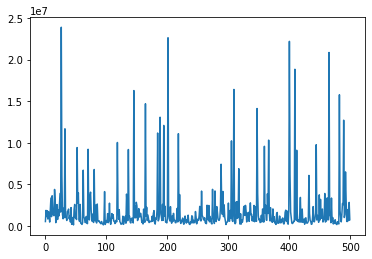

In [324]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(0, 500)], losses)

In [ ]:
tensor([ 961.,  154.,  905.,  225., 1071.])


In [325]:
model.state_dict()

OrderedDict([('conv2d.weight',
              tensor([[[[ 0.8274,  0.0433, -0.1156],
                        [ 0.0155, -0.0241, -0.0997],
                        [-0.1117,  0.1535,  0.4882]],
              
                       [[ 0.0113, -0.1913,  0.1276],
                        [ 0.1535,  0.1032, -0.1243],
                        [ 0.0062, -0.0449, -0.1188]],
              
                       [[ 0.0311, -0.0398,  0.1337],
                        [-0.1382,  0.0315, -0.0557],
                        [ 0.1251, -0.0973,  0.1266]]]])),
             ('linear.weight',
              tensor([[ 0.1597,  0.1028,  0.0282,  0.1274,  0.0646,  0.0025,  0.0762,  0.1316,
                        0.0144,  0.0333,  0.0053, -0.0185, -0.0429,  0.1084,  0.0067,  0.1860,
                        0.0391, -0.0948,  0.1272,  0.0605,  0.0581,  0.0198, -0.0128,  0.2352,
                        0.1412, -0.0485,  0.0587,  0.0415, -0.0881,  0.1068, -0.0429,  0.1304,
                        0.0933, -0.0613,  0.

In [326]:
Y

tensor([ 21., 129.,  53., 315., 788., 194.,  73.,   0., 205., 613.])

In [327]:
new_model = QuantumCicuitNet(n_vals, n_dim, 10)
new_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [328]:
lst = [i for i in range(0, 100)]

obs = [lst[i:i + 10] for i in range(0, len(lst), 10)]

In [329]:
obs

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
 [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]

In [330]:
thetas

[0.49095158296180824,
 0.4838279001803964,
 0.4736039638686407,
 0.49051681000795117,
 0.4000707665986359]

In [333]:
for subset in obs:

    x = np.array([list(i)[0:5] for i in X[subset]])
    Y = torch.tensor(y.detach().numpy()[subset])

    y_pred, grad = new_model(torch.tensor(x), thetas)
    print(y_pred, Y)
    # loss = criterion(y_pred, Y)
    # losses.append(loss)

    # print("    Loss: ", loss)
    # print("    MAE: ", mae(y_pred, Y))


    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    # thetas = [i.item() for i in list(torch.tensor(thetas) + (grad * lr))]

    # print("\n")

tensor([299.4494, 261.7351, 212.9859, 273.0739, 327.8275, 323.5872, 397.0389,
        286.1230, 278.6713, 292.8175], grad_fn=<AddBackward0>) tensor([ 961.,  154.,  905.,  225., 1071.,  337.,  204.,  320.,   61., 2063.])
tensor([299.6561, 260.7871, 212.4259, 272.4818, 325.6401, 320.6835, 395.9206,
        285.3967, 279.2459, 292.2944], grad_fn=<AddBackward0>) tensor([125., 170., 378., 318., 777., 201., 427., 187., 133., 304.])
tensor([301.4765, 261.3993, 213.3091, 273.5627, 326.0130, 321.8788, 397.4525,
        286.3386, 278.9607, 292.0437], grad_fn=<AddBackward0>) tensor([479., 464., 163., 772.,  57., 219., 211.,  80., 267., 307.])
tensor([299.6801, 260.6174, 212.9865, 272.7548, 327.0953, 321.6729, 396.1451,
        285.4586, 278.9039, 292.9017], grad_fn=<AddBackward0>) tensor([ 198., 1048.,  229.,  413.,  460.,  121.,  255.,  147.,  136.,  157.])
tensor([300.3280, 261.6816, 214.9083, 275.2155, 328.8141, 322.4049, 396.6836,
        288.2734, 280.3875, 296.0410], grad_fn=<AddBackward0>)